# Overview

1448棟のビルの4種類のメーター（電力、冷水、スチーム、温水）の値を予測するコンペである。

背景としては、エネルギー使用量（4種類のメーターの値）が正確に予測できるようになることで<br>
省エネ投資を活発化させて、環境問題に貢献したいという狙いがある。

ビルの所有者は、ビルのエネルギー効率を改善するような投資を行うことで<br>
エネルギー効率が改善された分、コストを抑えることができる。

# Module

In [1]:
import gc
import sys
import optuna
import datetime
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

# Datasets

In [2]:
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')

print(train.shape)
train.head()

(20216100, 4)


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


1時間ごとのメータ値を保持するテーブル（学習データ）<br>
・building_id：ビルのID<br>
・meter：0は電力、1は冷水、2はスチーム、3は温水<br>
・timestamp：日付と時刻<br>
・meter_reading：メーターの使用量（目的変数）<br>

In [3]:
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')

print(test.shape)
test.head()

(41697600, 4)


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


1時間ごとのメータ値を保持するテーブル（テストデータ）<br>
・row_id：行のID<br>
・building_id：ビルのID<br>
・meter：0は電力、1は冷水、2はスチーム、3は温水<br>
・timestamp：日付と時刻<br>

In [4]:
# 特徴量の選定を行う

In [5]:
usecols = {'site_id', 'timestamp', 'air_temperature', 'dew_temperature'}

In [6]:
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv', usecols=usecols)

print(weather_train.shape)
weather_train.head()

(139773, 4)


,site_id,timestamp,air_temperature,dew_temperature
0,0,2016-01-01 00:00:00,25.0,20.0
1,0,2016-01-01 01:00:00,24.4,21.1
2,0,2016-01-01 02:00:00,22.8,21.1
3,0,2016-01-01 03:00:00,21.1,20.6
4,0,2016-01-01 04:00:00,20.0,20.0


気象情報を保持するテーブル（学習データに対応）<br>
・site_id：ビルの物理的な位置<br>
・timestamp：日付と時刻<br>
・air_temperature：気温<br>
・dew_temperature：湿度<br>
・precip_depth：降水量<br>
・sea_level_pressure：海圧<br>
・wind_direction：風向<br>
・wind_speed：風速<br>

In [7]:
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv', usecols=usecols)

print(weather_test.shape)
weather_test.head()

(277243, 4)


,site_id,timestamp,air_temperature,dew_temperature
0,0,2017-01-01 00:00:00,17.8,11.7
1,0,2017-01-01 01:00:00,17.8,12.8
2,0,2017-01-01 02:00:00,16.1,12.8
3,0,2017-01-01 03:00:00,17.2,13.3
4,0,2017-01-01 04:00:00,16.7,13.3


気象情報を保持するテーブル（テストデータに対応）<br>
・site_id：ビルの物理的な位置<br>
・timestamp：日付と時刻<br>
・air_temperature：気温<br>
・dew_temperature：湿度<br>
・precip_depth：降水量<br>
・sea_level_pressure：海圧<br>
・wind_direction：風向<br>
・wind_speed：風速<br>

In [8]:
usecols = {'site_id', 'building_id', 'primary_use', 'square_feet', 'year_built', 'floor_count'}

In [9]:
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv', usecols=usecols)

print(building.shape)
building.head()

(1449, 6)


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


ビルの情報を保持するテーブル<br>
・site_id：ビルの物理的な位置<br>
・building_id：ビルのID<br>
・primary_use：使用目的<br>
・square_feet：面積<br>
・year_built：施工した年<br>
・floor_count：階数<br>

# Join

In [10]:
def reduce_mem_usage(df, use_float16=False):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [11]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

Memory usage of dataframe is 4.27 MB
Memory usage after optimization is: 1.79 MB
Decreased by 58.1%
Memory usage of dataframe is 8.46 MB
Memory usage after optimization is: 3.55 MB
Decreased by 58.1%


In [12]:
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

print(train.shape)
train.head()

(20216100, 9)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN


In [13]:
del building
gc.collect()

131

In [14]:
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

print(train.shape)
train.head()

(20216100, 11)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,20.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,20.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,20.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,20.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,20.0


In [15]:
del weather_train, weather_test
gc.collect()

40

In [16]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [17]:
print(sys.getsizeof(train))
print(sys.getsizeof(test))

4393476701
9063691712


In [18]:
train.memory_usage()

Index              161728800
building_id        161728800
meter              161728800
timestamp          161728800
meter_reading      161728800
site_id            161728800
primary_use        161728800
square_feet        161728800
year_built         161728800
floor_count        161728800
air_temperature     80864400
dew_temperature     80864400
dtype: int64

In [19]:
test.memory_usage()

Index              333580800
row_id             333580800
building_id        333580800
meter              333580800
timestamp          333580800
site_id            333580800
primary_use        333580800
square_feet        333580800
year_built         333580800
floor_count        333580800
air_temperature    166790400
dew_temperature    166790400
dtype: int64

# Analytics

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   building_id      int64  
 1   meter            int64  
 2   timestamp        object 
 3   meter_reading    float64
 4   site_id          int64  
 5   primary_use      object 
 6   square_feet      int64  
 7   year_built       float64
 8   floor_count      float64
 9   air_temperature  float32
 10  dew_temperature  float32
dtypes: float32(2), float64(3), int64(4), object(2)
memory usage: 1.7+ GB


In [21]:
for i in train.columns:
    print('{}: {}'.format(i, train[i].nunique()))

building_id: 1449
meter: 4
timestamp: 8784
meter_reading: 1688175
site_id: 16
primary_use: 16
square_feet: 1397
year_built: 116
floor_count: 18
air_temperature: 619
dew_temperature: 522


In [22]:
train.isnull().sum()

building_id               0
meter                     0
timestamp                 0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
year_built         12127645
floor_count        16709167
air_temperature       96658
dew_temperature      100140
dtype: int64

In [23]:
train.corr()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,dew_temperature
building_id,1.000000,0.222268,0.008761,0.980975,0.087704,-0.246150,-0.348353,-0.314149,-0.110091
meter,0.222268,1.000000,0.017672,0.253875,0.132708,-0.003798,0.176926,-0.011159,-0.080445
meter_reading,0.008761,0.017672,1.000000,0.011897,0.024308,0.111837,0.130224,-0.004132,-0.003330
site_id,0.980975,0.253875,0.011897,1.000000,0.090934,-0.212378,-0.336626,-0.307199,-0.135186
square_feet,0.087704,0.132708,0.024308,0.090934,1.000000,0.135717,0.584495,-0.015665,-0.023385
year_built,-0.246150,-0.003798,0.111837,-0.212378,0.135717,1.000000,0.147381,0.174156,0.117523
floor_count,-0.348353,0.176926,0.130224,-0.336626,0.584495,0.147381,1.000000,-0.183969,-0.174681
air_temperature,-0.314149,-0.011159,-0.004132,-0.307199,-0.015665,0.174156,-0.183969,1.000000,0.750640
dew_temperature,-0.110091,-0.080445,-0.003330,-0.135186,-0.023385,0.117523,-0.174681,0.750640,1.000000


# Visualization

In [24]:
sns.set()

In [25]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [26]:
# 7月以降、メータの数値が低いのが気になる、外れ値の可能性はないか

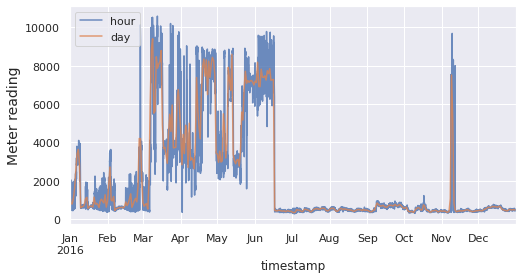

In [27]:
fig, axes = plt.subplots(figsize=(8, 4))
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='day', alpha=0.8).set_ylabel('Meter reading', fontsize=14)
axes.legend()

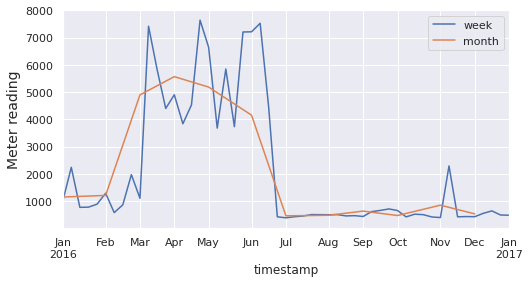

In [28]:
fig, axes = plt.subplots(figsize=(8, 4))
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('W').mean()['meter_reading'].plot(ax=axes, label='week', alpha=1).set_ylabel('Meter reading', fontsize=14)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('M').mean()['meter_reading'].plot(ax=axes, label='month', alpha=1).set_ylabel('Meter reading', fontsize=14)
axes.legend()

# Feature Engineering

In [29]:
train['hour'] = train['timestamp'].dt.hour
train['day'] = train['timestamp'].dt.day
train['weekend'] = train['timestamp'].dt.weekday
train['month'] = train['timestamp'].dt.month

In [30]:
# ラグ特徴量

In [31]:
train = train.drop(['timestamp', 'site_id'], axis=1)
gc.collect()

train = reduce_mem_usage(train)

Memory usage of dataframe is 2005.08 MB
Memory usage after optimization is: 771.18 MB
Decreased by 61.5%


In [32]:
print(train.shape)
train.head()

(20216100, 13)


,building_id,meter,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,hour,day,weekend,month
0,0,0,0.0,Education,7432,2008.0,NaN,25.0,20.0,0,1,4,1
1,1,0,0.0,Education,2720,2004.0,NaN,25.0,20.0,0,1,4,1
2,2,0,0.0,Education,5376,1991.0,NaN,25.0,20.0,0,1,4,1
3,3,0,0.0,Education,23685,2002.0,NaN,25.0,20.0,0,1,4,1
4,4,0,0.0,Education,116607,1975.0,NaN,25.0,20.0,0,1,4,1


# Preprocess

In [33]:
# drop_col = ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'floor_count']      

In [34]:
# train = train.drop(drop_col, axis = 1)
# gc.collect()

In [35]:
le = LabelEncoder()

train['primary_use'] = le.fit_transform(train['primary_use'])
test['primary_use'] = le.fit_transform(test['primary_use'])

In [36]:
target = np.log1p(train['meter_reading'])
train = train.drop(['meter_reading'], axis=1)

print(train.shape)
train.head()

(20216100, 12)


,building_id,meter,primary_use,square_feet,year_built,floor_count,air_temperature,dew_temperature,hour,day,weekend,month
0,0,0,0,7432,2008.0,NaN,25.0,20.0,0,1,4,1
1,1,0,0,2720,2004.0,NaN,25.0,20.0,0,1,4,1
2,2,0,0,5376,1991.0,NaN,25.0,20.0,0,1,4,1
3,3,0,0,23685,2002.0,NaN,25.0,20.0,0,1,4,1
4,4,0,0,116607,1975.0,NaN,25.0,20.0,0,1,4,1


In [37]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [38]:
del le
gc.collect()

140

In [39]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 674.79 MB
Memory usage after optimization is: 539.83 MB
Decreased by 20.0%
Memory usage of dataframe is 3181.27 MB
Memory usage after optimization is: 1471.34 MB
Decreased by 53.7%


In [40]:
print(sys.getsizeof(train))
print(sys.getsizeof(test))

566050960
1542811360


# Modeling

In [41]:
'''
X_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)

def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        metric='rsme',
        random_state=666)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rsme = np.sqrt(mean_squared_error(y_pred, y_val))
    return rsme

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
params = study.best_params
print(params)
'''

"\nX_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)\n\ndef create_model(trial):\n    num_leaves = trial.suggest_int('num_leaves', 2, 30)\n    n_estimators = trial.suggest_int('n_estimators', 50, 300)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    max_depth = trial.suggest_int('max_depth', 2, 10)\n    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)\n    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)\n    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)\n    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n    \n    model = lgb.LGBMRegressor(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_rate

In [42]:
# rsme: 0.8751749628536593

params = {'num_leaves': 29,
          'n_estimators': 259,
          'learning_rate': 0.6767825229671494,
          'max_depth': 7,
          'min_child_samples': 991,
          'min_data_in_leaf': 51,
          'bagging_freq': 4,
          'bagging_fraction': 0.7298919866619639,
          'feature_fraction': 0.875247529005268,
          'subsample': 0.315064279924561,
          'colsample_bytree': 0.67995244232174,
          'random_state': 666}

In [43]:
'''
# rsme: 0.9077297841386155

params = {'num_leaves': 15,
          'n_estimators': 300,
          'learning_rate': 0.9849803475916162,
          'max_depth': 8,
          'min_child_samples': 852,
          'min_data_in_leaf': 57,
          'bagging_freq': 6,
          'bagging_fraction': 0.45951000229116346,
          'feature_fraction': 0.9981667070528089,
          'subsample': 0.1064524138387621,
          'colsample_bytree': 0.9853399903480412,
          'random_state': 666}
'''

"\n# rsme: 0.9077297841386155\n\nparams = {'num_leaves': 15,\n          'n_estimators': 300,\n          'learning_rate': 0.9849803475916162,\n          'max_depth': 8,\n          'min_child_samples': 852,\n          'min_data_in_leaf': 57,\n          'bagging_freq': 6,\n          'bagging_fraction': 0.45951000229116346,\n          'feature_fraction': 0.9981667070528089,\n          'subsample': 0.1064524138387621,\n          'colsample_bytree': 0.9853399903480412,\n          'random_state': 666}\n"

In [44]:
cls = lgb.LGBMRegressor(**params)
cls.fit(train, target)

[LightGBM] [Warning] bagging_fraction is set=0.7298919866619639, subsample=0.315064279924561 will be ignored. Current value: bagging_fraction=0.7298919866619639
[LightGBM] [Warning] feature_fraction is set=0.875247529005268, colsample_bytree=0.67995244232174 will be ignored. Current value: feature_fraction=0.875247529005268
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=991 will be ignored. Current value: min_data_in_leaf=51


LGBMRegressor(bagging_fraction=0.7298919866619639, bagging_freq=4,
              colsample_bytree=0.67995244232174,
              feature_fraction=0.875247529005268,
              learning_rate=0.6767825229671494, max_depth=7,
              min_child_samples=991, min_data_in_leaf=51, n_estimators=259,
              num_leaves=29, random_state=666, subsample=0.315064279924561)

In [45]:
del train, target, params
gc.collect()

99

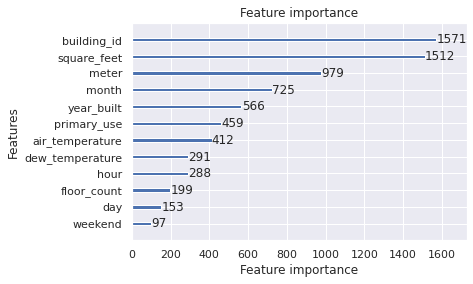

In [46]:
lgb.plot_importance(cls)
plt.show()

# Submit

In [47]:
row_id = test['row_id']

test = test.drop(['row_id'], axis = 1)
gc.collect()

4819

In [48]:
test['hour'] = test['timestamp'].dt.hour
test['day'] = test['timestamp'].dt.day
test['weekend'] = test['timestamp'].dt.weekday
test['month'] = test['timestamp'].dt.month

In [49]:
test = test.drop(['timestamp', 'site_id'], axis=1)
gc.collect()

55

In [50]:
row_id = row_id.reset_index(drop=True)
test = test.reset_index(drop=True)

test = reduce_mem_usage(test)

Memory usage of dataframe is 2226.89 MB
Memory usage after optimization is: 1113.45 MB
Decreased by 50.0%


In [51]:
print(pd.DataFrame([[i for i in dir()], [sys.getsizeof(eval(i)) for i in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True).head(10))

     name        size
0    test  1167532960
1  row_id   166790560
2     _32        1919
3    _i10        1787
4    _i41        1745
5     _41        1739
6     _23        1591
7     _18        1235
8     _19        1228
9     _oh        1192


In [52]:
target = np.expm1(cls.predict(test))

submission = pd.DataFrame(target, index=row_id, columns=['meter_reading'])
submission.head(10)

,meter_reading
row_id,
0,-0.081565
1,0.411655
2,-0.292215
3,-0.156384
4,-0.081333
5,-0.028558
6,-0.079388
7,-0.085697
8,297.446544


In [53]:
del row_id
gc.collect()

submission = reduce_mem_usage(submission)

Memory usage of dataframe is 636.25 MB
Memory usage after optimization is: 477.19 MB
Decreased by 25.0%


In [54]:
submission.to_csv('ASHRAE_submit.csv')